In [1]:
import pandas as pd 
import csv 
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 
import sktime 
from datetime import timedelta
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import grangercausalitytests

from time import time
import seaborn as sns
sns.set(style="whitegrid")
import seaborn as sns
import shap
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [3]:
weekly_sales = pd.read_csv('weekly_sales.csv')
weekly_sales = weekly_sales.set_index('Day')
weekly_sales.index = pd.to_datetime(weekly_sales.index)
weekly_sales.head()

,Sales (USD),Wash (USD),Trade Profit,Supply,Eth price (USD),Bitcoin price,Gas Price,Anomalies,Seller Buyer ratio,Wash Transaction ratio
Day,,,,,,,,,,
2019-01-01,4416.38,8.35,0.00,4030.0,139.61,3809.4,14.330651,0,0.648148,0.004587
2019-01-02,6189.77,2685.46,38.61,125.0,152.95,3873.8,13.518334,0,1.225806,0.050360
2019-01-03,5486.61,1492.68,2.21,1417.0,146.94,3780.1,12.695511,0,1.222222,0.021277
2019-01-04,8053.08,843.21,1.51,1438.0,152.86,3802.7,14.197164,0,0.937500,0.036000
2019-01-05,6769.97,423.57,172.86,136.0,153.49,3785.4,24.120227,0,0.858824,0.048485


In [4]:
keywords = pd.read_csv('NFT Keywords.csv')
keywords = keywords.set_index('Week')
keywords = keywords.dropna()
keywords = keywords.astype(int)

In [5]:
keywords_group = pd.DataFrame(columns = ['Neutral Phrases', 'Basic', 'Negative'])

keywords_group['Neutral Phrases'] = (keywords['NFT Art '] + keywords['bored ape yatch club nft'] + 
                                    + keywords['crypto'] + keywords['cryptozoo nft']  +
                                     + keywords['nft discord'] 
                                    + keywords['nft marketplace'] + keywords['opensea discord'] 
                                    + keywords['opensea nft']
                                    + keywords['opensea marketplace']) / 9
                    
keywords_group['Basic'] =  (keywords['Blockchain']+ keywords['Ethereum'] + keywords['Bitcoin'] +
                           keywords['NFT'] + keywords['Cryptocurrency']) / 5

keywords_group['Negative'] = (keywords['is nft a scam'] + keywords['nft scam'] + keywords['nft wash trading']
                             + keywords['wash sale crypto'] + keywords['rug pull nft'] + 
                              keywords['opensea phishing']
        + keywords['free nft'] + keywords['crypto giveaway twitter'] + keywords['twitter giveaway']) / 9

keywords_group['Positive'] = (keywords['buy nft'] + keywords['sell nft'] + keywords['NFT future'] +
                              keywords['NFT guide'] + keywords['NFT investment']) / 5

<AxesSubplot:xlabel='Week'>

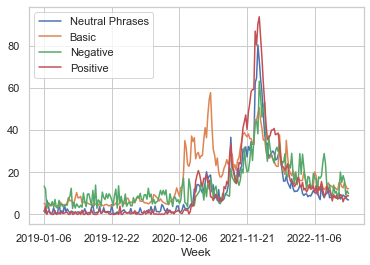

In [6]:
keywords_group = keywords_group.round(1) 
keywords_group.plot()

In [7]:
volatility = pd.DataFrame()
volatility['Eth Volatility'] = weekly_sales['Eth price (USD)'].resample('W').std()
volatility['Btc Volatility'] = weekly_sales['Bitcoin price'].resample('W').std()
weekly_sum = weekly_sales.resample('W').sum()
weekly_sales_final = weekly_sum
weekly_sales_final = weekly_sales_final.drop(['Anomalies','Supply','Seller Buyer ratio',
                                              'Eth price (USD)','Bitcoin price','Gas Price'],axis=1)

weekly_sales_final['Neutral Phrases'] = keywords_group['Neutral Phrases'].values
weekly_sales_final['Basic'] = keywords_group['Basic'].values
weekly_sales_final['Negative'] = keywords_group['Negative'].values
weekly_sales_final['Positive'] = keywords_group['Positive'].values
weekly_sales_final = weekly_sales_final.round(decimals =2)

# Sales, Volatility, Search Interest

In [8]:
sales_google_trends = weekly_sales_final[['Sales (USD)','Neutral Phrases','Basic','Negative','Positive']].copy()

In [9]:
sales_google_trends['Eth Volatility'] = volatility['Eth Volatility']
sales_google_trends['Btc Volatility'] = volatility['Btc Volatility']

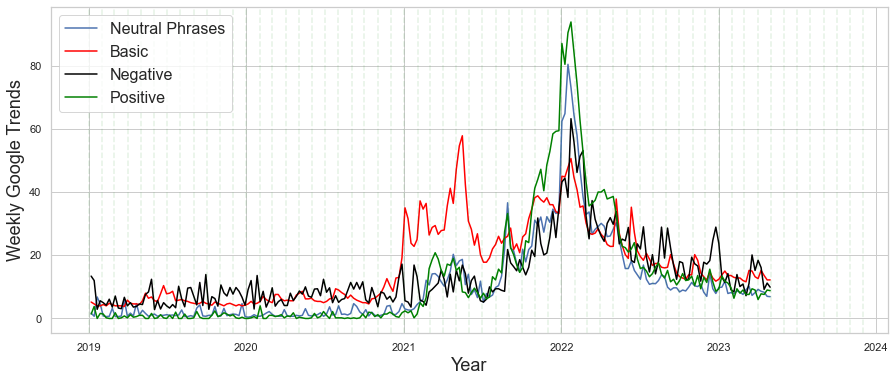

In [10]:
plt.figure(figsize=(15,6))
neutral, = plt.plot(sales_google_trends['Neutral Phrases'])
basic, = plt.plot(sales_google_trends['Basic'], color='red')
negative, = plt.plot(sales_google_trends['Negative'], color='black')
positive, = plt.plot(sales_google_trends['Positive'], color='green')

plt.xlabel('Year',fontsize=18)
plt.ylabel('Weekly Google Trends',fontsize=18)
for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.1)

plt.legend(['Neutral Phrases', 'Basic','Negative','Positive'], fontsize=16)

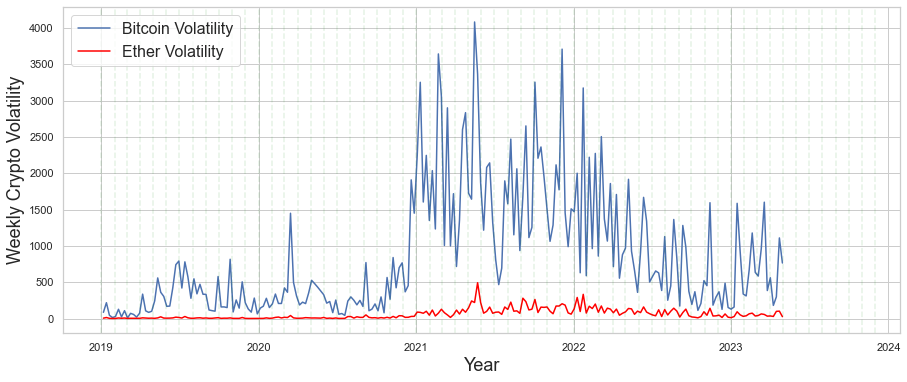

In [11]:
plt.figure(figsize=(15,6))
btc, = plt.plot(sales_google_trends['Btc Volatility'])
eth, = plt.plot(sales_google_trends['Eth Volatility'], color='red')

plt.xlabel('Year',fontsize=18)
plt.ylabel('Weekly Crypto Volatility',fontsize=18)
for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.1)

plt.legend(['Bitcoin Volatility','Ether Volatility'], fontsize=16)

## Check Stationarity

In [12]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
print('Augmented Dickey-Fuller Test: Sales Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Sales (USD)'])

print('Augmented Dickey-Fuller Test: Neutral Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Neutral Phrases'])

print('Augmented Dickey-Fuller Test: Basic Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Basic'])

print('Augmented Dickey-Fuller Test: Negative Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Negative'])

print('Augmented Dickey-Fuller Test: Positive Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Positive'])

print('Augmented Dickey-Fuller Test: ETH Volatility Time Series')
augmented_dickey_fuller_statistics(sales_google_trends['Eth Volatility'])

print('Augmented Dickey-Fuller Test: BTC Volatililty')
augmented_dickey_fuller_statistics(sales_google_trends['Btc Volatility'])



Augmented Dickey-Fuller Test: Sales Time Series
ADF Statistic: -2.320922
p-value: 0.165309
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Neutral Time Series
ADF Statistic: -2.043033
p-value: 0.268029
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Basic Time Series
ADF Statistic: -1.897556
p-value: 0.333212
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Negative Time Series
ADF Statistic: -2.170729
p-value: 0.217040
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Positive Time Series
ADF Statistic: -1.728412
p-value: 0.416536
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: ETH Volatility Time Series
ADF Statistic: -1.505669
p-value: 0.530705
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: BTC Volatililty
ADF Statistic: -1.758756
p-value: 0.401122
Critical Values:
	1%: -3

In [13]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in sales_google_trends.columns: 
    kpss_res = kpss(sales_google_trends[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=sales_google_trends.columns).T
kpss_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Positive,Eth Volatility,Btc Volatility
Test statistic,0.2107,0.2051,0.3316,0.1651,0.1942,0.3598,0.3624
p-value,0.0120,0.0141,0.0100,0.0341,0.0182,0.0100,0.0100
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


In [14]:
stationary = sales_google_trends.diff().dropna()

In [15]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
print('Augmented Dickey-Fuller Test: Sales Time Series')
augmented_dickey_fuller_statistics(stationary['Sales (USD)'])

print('Augmented Dickey-Fuller Test: Neutral Time Series')
augmented_dickey_fuller_statistics(stationary['Neutral Phrases'])

print('Augmented Dickey-Fuller Test: Basic Time Series')
augmented_dickey_fuller_statistics(stationary['Basic'])

print('Augmented Dickey-Fuller Test: Negative Time Series')
augmented_dickey_fuller_statistics(stationary['Negative'])

print('Augmented Dickey-Fuller Test: Positive Time Series')
augmented_dickey_fuller_statistics(stationary['Positive'])

print('Augmented Dickey-Fuller Test: ETH Volatility Time Series')
augmented_dickey_fuller_statistics(stationary['Eth Volatility'])

print('Augmented Dickey-Fuller Test: BTC Volatililty')
augmented_dickey_fuller_statistics(stationary['Btc Volatility'])


Augmented Dickey-Fuller Test: Sales Time Series
ADF Statistic: -13.995272
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Neutral Time Series
ADF Statistic: -4.852386
p-value: 0.000043
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Basic Time Series
ADF Statistic: -6.722637
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Negative Time Series
ADF Statistic: -15.849198
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Positive Time Series
ADF Statistic: -6.848775
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: ETH Volatility Time Series
ADF Statistic: -8.269466
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: BTC Volatililty
ADF Statistic: -9.144725
p-value: 0.000000
Critical Values:
	1%: 

In [16]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in stationary.columns: 
    kpss_res = kpss(stationary[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=stationary.columns).T
kpss_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Positive,Eth Volatility,Btc Volatility
Test statistic,0.0657,0.0447,0.0674,0.0807,0.0621,0.1018,0.0859
p-value,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


# VAR

In [17]:
model = VAR(stationary)
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,69.18,69.29,1.112e+30,69.23
1,67.99,68.87*,3.380e+29,68.35
2,67.57,69.22,2.222e+29,68.24*
3,67.32,69.73,1.727e+29,68.29
4,67.25,70.44,1.632e+29,68.54
5,67.00,70.95,1.277e+29,68.59
6,67.01,71.73,1.311e+29,68.91
7,66.93,72.42,1.242e+29,69.15
8,66.70,72.95,1.013e+29,69.22
9,66.16,73.19,6.170e+28,69.00


In [18]:
x.aic, x.bic, x.fpe, x.hqic

(10, 1, 10, 2)

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_statistic, p_value = acorr_ljungbox(sales_google_trends['Sales (USD)'], lags=10)

print("Ljung-Box Statistic:", ljungbox_statistic)
print("P-value:", p_value)

Ljung-Box Statistic: lb_stat
P-value: lb_pvalue


In [20]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank1 = select_coint_rank(sales_google_trends, det_order = 1, k_ar_diff = 1,
                                   method = 'trace', signif=0.01)
print(rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          395.3          150.1
  1   7          276.7          117.0
  2   7          177.2          87.77
  3   7          100.7          62.52
  4   7          39.26          41.08
-------------------------------------


In [21]:
rank2 = select_coint_rank(sales_google_trends, det_order = 1, k_ar_diff = 1, 
                              method = 'maxeig', signif=0.01)

print(rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          118.6          55.82
  1   2          99.48          49.41
  2   3          76.51          42.86
  3   4          61.44          36.19
  4   5          21.64          29.26
-------------------------------------


In [22]:
vecm = VECM(sales_google_trends, k_ar_diff=1, coint_rank = 4, deterministic='ci')
"""estimates the VECM on the prices with 3 lags, 3 cointegrating relationship, and 
a constant within the cointegration relationship"""
vecm_fit = vecm.fit()
print(vecm_fit.summary())

NameError: name 'VECM' is not defined

In [23]:
from statsmodels.tsa.vector_ar import irf
irf = vecm_fit.irf(15)
irf.plot(orth = False)
plt.show()

NameError: name 'vecm_fit' is not defined

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 3
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(stationary, variables = stationary.columns)

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    """
    Perform the Johansen Cointegration Test on a DataFrame.
    
    Parameters:
        df (DataFrame): The DataFrame containing the time series data
        alpha (float): Significance level for the test
    
    Returns:
        None: Prints the summary of the test
    """
    test_result = coint_johansen(df, det_order=0, k_ar_diff=2)
    for col, trace, cvt, cvm in zip(df.columns, test_result.lr1, test_result.cvt[:, 0], test_result.cvm[:, 0]):
        print(f'{col}, Trace Stat: {trace:.2f}, 95% Critical Value: {cvt:.2f}, 90% Critical Value: {cvm:.2f}')
        if trace > cvt:
            print('=> Cointegration exists at 95% significance level')
        elif trace > cvm:
            print('=> Cointegration exists at 90% significance level')
        else:
            print('=> No Cointegration')

# Run the cointegration test on your data
cointegration_test(sales_google_trends)


In [32]:
from statsmodels.tsa.api import VECM

vecm_model = VECM(stationary, coint_rank=3)
vecm_fit = vecm_model.fit()

In [34]:
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Sales (USD)
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.Sales (USD)        -0.1774      0.070     -2.539      0.011      -0.314      -0.040
L1.Neutral Phrases -3.356e+05   3.36e+06     -0.100      0.921   -6.93e+06    6.26e+06
L1.Basic            7.705e+06   3.37e+06      2.285      0.022     1.1e+06    1.43e+07
L1.Negative        -4.973e+05   2.36e+06     -0.211      0.833   -5.12e+06    4.13e+06
L1.Positive         6.337e+06   2.88e+06      2.197      0.028    6.84e+05     1.2e+07
L1.Eth Volatility  -6.055e+05   2.78e+05     -2.180      0.029   -1.15e+06   -6.12e+04
L1.Btc Volatility  -3.334e+04   2.23e+04     -1.495      0.135   -7.71e+04    1.04e+04
Det. terms outside the coint. relation & lagged endog. parameters for equation Neutral Phrases
                         coef  

# VECM


# Check for cointegration

In [35]:
sales_google_trends1 = sales_google_trends
constant = 1e-10
sales_google_trends1 += constant
log_diff_df = np.log(sales_google_trends1)
log_diff_df = log_diff_df.dropna()
log_diff_df

,Sales (USD),Neutral Phrases,Basic,Negative,Positive,Eth Volatility,Btc Volatility
Day,,,,,,,
2019-01-06,10.54,0.53,1.65,2.60,0.34,1.77,4.45
2019-01-13,10.70,-0.36,1.53,2.48,1.34,2.69,5.39
2019-01-20,10.98,1.92,1.39,1.06,-22.33,1.18,3.81
2019-01-27,11.35,1.53,1.39,1.72,0.47,0.57,2.69
2019-02-03,11.49,-0.22,1.48,1.61,0.34,0.65,3.32
2019-02-10,11.51,-0.51,1.39,1.44,-1.61,2.12,4.85
2019-02-17,11.15,-0.36,1.57,1.81,-22.33,1.51,3.15
2019-02-24,11.04,1.16,1.48,1.28,-22.33,2.02,4.69
2019-03-03,11.38,-0.51,1.39,1.96,0.59,0.88,2.14


In [36]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Your data preparation step
# mdata is assumed to be previously defined
# data = mdata[["realgdp","realcons", "realinv"]].pct_change().dropna()

def cointegration_test(data, alpha=0.05): 
    """
    Perform Johansen's Cointegration Test and Report Summary
    """
    
    # Perform the Johansen Test
    out = coint_johansen(data, -1, 2)
    
    # Significance levels: keys are p-values, values are critical values
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): 
        return str(val).ljust(length)
    
    # Summary
    print('Name   ::  Trace Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# Run the cointegration test
cointegration_test(sales_google_trends)




Name   ::  Trace Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales (USD) ::  281.04    > 111.7797  =>   True
Neutral Phrases ::  174.0     > 83.9383   =>   True
Basic  ::  100.63    > 60.0627   =>   True
Negative ::  47.37     > 40.1749   =>   True
Positive ::  22.36     > 24.2761   =>   False
Eth Volatility ::  10.14     > 12.3212   =>   False
Btc Volatility ::  0.92      > 4.1296    =>   False


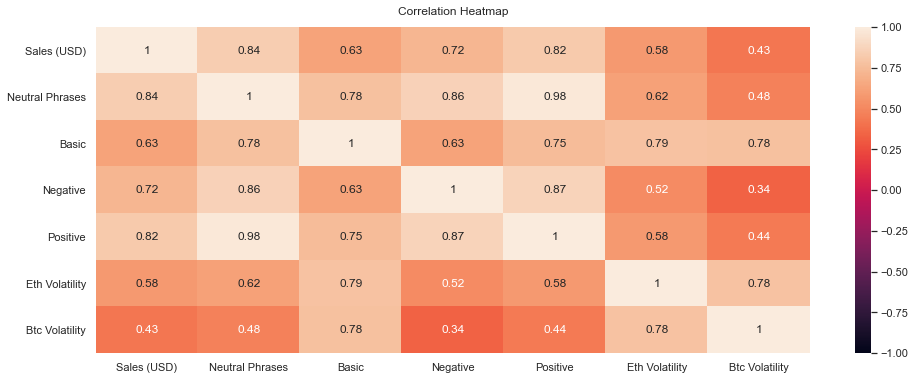

In [37]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(sales_google_trends.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [38]:
from statsmodels.tsa.vector_ar import vecm

model = vecm.select_order(sales_google_trends, maxlags=4)
print(model.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       66.71      67.57*   9.373e+28      67.06*
1       66.61       68.23   8.502e+28       67.26
2       66.41       68.77   6.949e+28       67.36
3       66.39       69.52   6.903e+28       67.65
4      66.31*       70.18  6.393e+28*       67.87
-------------------------------------------------


In [39]:
from statsmodels.tsa.vector_ar.vecm import select_order

lag_order_results = select_order(sales_google_trends, maxlags=4, deterministic="ci", seasons=0)

print(lag_order_results.selected_orders)

{'aic': 4, 'bic': 0, 'hqic': 0, 'fpe': 4}


In [40]:
# Johansen co-integration
pd.options.display.float_format = "{:.2f}".format
"""definition of det_orderint:
-1 - no deterministic terms; 0 - constant term; 1 - linear trend"""
pd.options.display.float_format = "{:.2f}".format
model = coint_johansen(endog = sales_google_trends, det_order = 1, k_ar_diff = 4)
print('Eigen statistic:')
print(model.eig) 
print()
print('Critical values:')
d = pd.DataFrame(model.cvt)
d.rename(columns = {0:'90%', 1: '95%', 2:'99%'}, inplace=True)
print(d); print()
print('Trace statistic:')
print(pd.DataFrame(model.lr1)) 

Eigen statistic:
[0.36614158 0.26274717 0.19558402 0.13874825 0.07386091 0.0398748
 0.01611125]

Critical values:
     90%    95%    99%
0 133.79 139.28 150.08
1 102.47 107.34 116.98
2  75.10  79.34  87.77
3  51.65  55.25  62.52
4  32.06  35.01  41.08
5  16.16  18.40  23.15
6   2.71   3.84   6.63

Trace statistic:
       0
0 278.78
1 178.01
2 110.65
3  62.55
4  29.54
5  12.58
6   3.59


In [41]:
# cointegration rank determination
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank1 = select_coint_rank(sales_google_trends, det_order = 1, k_ar_diff = 4,
                                   method = 'trace', signif=0.01)
print(rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          278.8          150.1
  1   7          178.0          117.0
  2   7          110.6          87.77
  3   7          62.55          62.52
  4   7          29.54          41.08
-------------------------------------


rank2 = select_coint_rank(sales_google_trends, det_order = 1, k_ar_diff = 7, 
                              method = 'maxeig', signif=0.01)

print(rank2.summary())

In [42]:
# VECM fitting
# VECM
vecm = VECM(sales_google_trends, k_ar_diff=1, coint_rank = 4, deterministic='ci')
"""estimates the VECM on the prices with 3 lags, 3 cointegrating relationship, and 
a constant within the cointegration relationshipdur"""
vecm_fit = vecm.fit()
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Sales (USD)
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.Sales (USD)        -0.0360      0.069     -0.519      0.604      -0.172       0.100
L1.Neutral Phrases   5.56e+06   3.96e+06      1.405      0.160    -2.2e+06    1.33e+07
L1.Basic           -2.422e+06   3.49e+06     -0.695      0.487   -9.25e+06    4.41e+06
L1.Negative         2.537e+06   2.06e+06      1.231      0.218    -1.5e+06    6.58e+06
L1.Positive         1.114e+07   3.91e+06      2.851      0.004    3.48e+06    1.88e+07
L1.Eth Volatility  -4.771e+05   2.53e+05     -1.888      0.059   -9.72e+05    1.82e+04
L1.Btc Volatility   2.435e+04   2.14e+04      1.139      0.255   -1.75e+04    6.62e+04
Det. terms outside the coint. relation & lagged endog. parameters for equation Neutral Phrases
                         coef  

In [43]:
# Residual auto-correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_fit.resid)
for col, val in zip(sales_google_trends.columns, out):
    print((col), ':', round(val, 2))

Sales (USD) : 2.06
Neutral Phrases : 2.06
Basic : 2.05
Negative : 2.04
Positive : 2.08
Eth Volatility : 2.0
Btc Volatility : 1.92


In [ ]:
plt.style.use('ggplot')
irf.plot()
plt.show()

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 4
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(stationary, variables = sales_google_trends.columns)

In [ ]:
alpha = vecm_fit.alpha
print(alpha)

In [ ]:
alpha_df = pd.DataFrame(alpha)
alpha_df

In [ ]:
gc_test = vecm_fit.test_granger_causality(caused='Neutral Phrases',causing='Sales (USD)')
print(gc_test.summary())

In [ ]:
variables = ['Sales (USD)', 'Neutral Phrases', 'Basic', 'Negative', 'Positive', 'Eth Volatility', 'Btc Volatility']

# Create an empty DataFrame to store results
gc_df = pd.DataFrame(index=variables, columns=variables)

for caused in variables:
    for causing in variables:
        if caused != causing:
            test_result = vecm_fit.test_granger_causality(caused=caused, causing=causing)
            # Assuming you want to store the p-value
            gc_df.loc[caused, causing] = test_result.pvalue
        else:
            gc_df.loc[caused, causing] = 1
            
gc_df.columns = [var + '_x' for var in variables]
gc_df.index = [var + '_y' for var in variables]

In [ ]:
gc_df

In [ ]:
test_result = vecm_fit.test_granger_causality(caused='Eth Volatility', causing='Btc Volatility')
print(test_result.summary())

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = sales_google_trends[sales_google_trends.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(sales_google_trends.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();